# Airfoil Self Noise

In [1]:
# set python to pick up local directory
from pathlib import Path
import sys
import os
path_root = str(Path(os.getcwd()).parents[0])
package_root = str(Path(os.getcwd()).parents[1])
sys.path.append(path_root)
sys.path.append(package_root)

# auto reload
%reload_ext autoreload
%autoreload 2

# hush
import warnings
warnings.simplefilter('always', category=FutureWarning)

In [2]:
from jax import config
config.update("jax_enable_x64", True)

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import jax
import jax.numpy as jnp
from jax import vmap, jit
from tensorflow_probability.substrates.jax import distributions as tfd
from jax.lib import xla_bridge

In [4]:
from steinRF import GP, LowRankGP, MixGP
from steinRF.gp.kernels import RFF
from steinRF.gp.transforms import Transform, ARD
from steinRF.stein.targets import TFTarget

from steinRF.stein.srfr import srfr
# from steinRF.mar_srfr import mar_srfr
from steinRF.utils import gp_cross_val, metric_model, run_hyperopt, mse, mae
from steinRF.baselines import build_svgp, build_train_svgp, svgp_predict, svgp_cross_val
from steinRF.baselines import orthogonal_gaussian
from steinRF.gp.models import *

In [5]:
jax.clear_caches()
print(f"device: {xla_bridge.get_backend().platform}")

device: gpu


## Data Preparation

In [6]:
key = jax.random.PRNGKey(0)

In [7]:
airfoil = pd.read_csv("airfoil.csv")
X_scaler = MinMaxScaler()
y_scaler = StandardScaler()
airfoil[
    ['frequency', 'angle', 'chord_length', 'velocity', 'thickness']
] = X_scaler.fit_transform(airfoil.drop(columns=["sound_pressure"]))
airfoil['sound_pressure'] = y_scaler.fit_transform(airfoil[['sound_pressure']])
# airfoil = pd.DataFrame(scaler.fit_transform(airfoil))
# airfoil.columns = ['frequency', 'angle', 'chord_length', 'velocity', 'thickness', 'sound_pressure']

X = jnp.array(airfoil.drop(columns=['sound_pressure']))
y = jnp.array(airfoil['sound_pressure'])
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.10, random_state=int(key[0]))
X_train, X_val, y_train, y_val = jnp.array(X_train), jnp.array(X_val), jnp.array(y_train), jnp.array(y_val)
d = X_train.shape[1]

## Hyperparameter Optimization

In [8]:
# total settings
diag_min, diag_max = 1e-4, 3e-1
epoch_min, epoch_max = 500, 5000
lr_min, lr_max = 1e-3, 4e-1
alpha_min, alpha_max = 0., 3.
q_min, q_max = 2, 10
s_vals = [0, 0.5, 1, 2]

# --------------------------------- Sparse Variational GP -------------------------------- #
def _svgp_cross_val(trial, key, X, y, **params):
    # hparams
    R = params.get('R')
    diag = params.get('diag', None)
    epochs = params.pop('epochs', None)
    if epochs is None:
        epochs = trial.suggest_int("epochs", epoch_min, epoch_max, step=500)
    lr = params.pop('lr', None)
    if lr is None:
        # lr = trial.suggest_float("lr", lr_min, lr_max, log=True)
        lr = trial.suggest_float("lr", 5e-4, 2e-1, log=True)  # modified due to numerical stability issues
    cv_params = {'R': R, 'epochs': epochs, 'lr': lr, 'diag': diag, **params}

    # run cross val
    cross_val_acc = svgp_cross_val(key, X, y, cv_params)
    return cross_val_acc


# ---------------------------------- RFF GP - RBF Kernel --------------------------------- #
def rff_rbf_cross_val(trial, key, X, y, **params):
    # hparams
    R = params.pop('R')
    diag = params.pop('diag', None)
    if diag is None:
        diag = trial.suggest_float("diag", diag_min, diag_max, log=True)
    epochs = params.pop('epochs', None)
    if epochs is None:
        epochs = trial.suggest_int("epochs", epoch_min, epoch_max, step=500)
    lr = params.pop('lr', None)
    if lr is None:
        lr = trial.suggest_float("lr", lr_min, lr_max, log=True)
    cv_params = {'R': R, 'epochs': epochs, 'lr': lr, 'diag': diag, **params}

    # run cross val
    cross_val_acc = gp_cross_val(build_train_rff_rbf, key, X, y, cv_params)
    return cross_val_acc


# --------------------------------------- RFF BASIC -------------------------------------- #
def rff_cross_val(trial, key, X, y, **params):
    # hparams
    R = params.pop('R')
    diag = params.pop('diag', None)
    if diag is None:
        diag = trial.suggest_float("diag", diag_min, diag_max, log=True)
    epochs = params.pop('epochs', None)
    if epochs is None:
        epochs = trial.suggest_int("epochs", epoch_min, epoch_max, step=500)
    lr = params.pop('lr', None)
    if lr is None:
        lr = trial.suggest_float("lr", lr_min, lr_max, log=True)
    cv_params = {'R': R, 'epochs': epochs, 'lr': lr, 'diag': diag, **params}

    # run cross val
    cross_val_acc = gp_cross_val(build_train_rff, key, X, y, cv_params)
    return cross_val_acc

# --------------------------------------- STEIN RFF -------------------------------------- #
def srf_cross_val(trial, key, X, y, **params):
    # hparams
    R = params.pop('R')

    diag = params.pop('diag', None)
    if diag is None:
        diag = trial.suggest_float("diag", diag_min, diag_max, log=True)
    epochs = params.pop('epochs', None)
    if epochs is None:
        epochs = trial.suggest_int("epochs", epoch_min, epoch_max, step=500)
    lr = params.pop('lr', None)
    if lr is None:
        lr = trial.suggest_float("lr", lr_min, lr_max, log=True)
    lr_gd = params.pop('lr_gd', None)
    if lr_gd is None:
        lr_gd = trial.suggest_float("lr_gd", lr_min, lr_max, log=True)
    alpha = params.pop('alpha', None)
    if alpha is None:
        alpha = trial.suggest_float("alpha", alpha_min, alpha_max, step=0.2)
    s = params.pop('s', None)
    if s is None:
        s = trial.suggest_categorical("s", s_vals)
    cv_params = {
        'R': R, 'epochs': epochs, 'lr': lr, 'lr_gd': lr_gd, 'diag': diag, 'alpha': alpha, 
        's': s, **params
    }
    # cv_params = {
    #     'R': R, 'epochs': epochs, 'lr': lr, 'diag': diag, 'alpha': alpha, 
    #     's': s, **params
    # }

    # run cross val
    cross_val_acc = gp_cross_val(build_train_srf, key, X, y, cv_params)
    return cross_val_acc


# ----------------------------------- NONSTATIONARY RFF ---------------------------------- #
def nrff_cross_val(trial, key, X, y, **params):
    # hparams
    R = params.get('R')
    diag = params.get('diag', None)
    if diag is None:
        diag = trial.suggest_float("diag", diag_min, diag_max, log=True)
    epochs = params.get('epochs', None)
    if epochs is None:
        epochs = trial.suggest_int("epochs", epoch_min, epoch_max, step=500)
    lr = params.get('lr', None)
    if lr is None:
        lr = trial.suggest_float("lr", lr_min, lr_max, log=True)

    cv_params = {'R': R, 'epochs': epochs, 'lr': lr, 'diag': diag, **params}

    # run cross val
    cross_val_acc = gp_cross_val(build_train_nrff, key, X, y, cv_params)
    return cross_val_acc


# ------------------------------------ MARGINAL KERNEL ----------------------------------- #
def mix_rff_cross_val(trial, key, X, y, **params):
    # hparams
    R = params.pop('R')

    diag = params.pop('diag', None)
    if diag is None:
        diag = trial.suggest_float("diag", diag_min, diag_max, log=True)
    epochs = params.pop('epochs', None)
    if epochs is None:
        epochs = trial.suggest_int("epochs", epoch_min, epoch_max, step=500)
    lr = params.pop('lr', None)
    if lr is None:
        lr = trial.suggest_float("lr", lr_min, lr_max, log=True)
    lr_gd = params.pop('lr_gd', None)
    if lr_gd is None:
        lr_gd = trial.suggest_float("lr_gd", lr_min, lr_max, log=True)
    alpha = params.pop('alpha', None)
    if alpha is None:
        alpha = trial.suggest_float("alpha", alpha_min, alpha_max, step=0.2)
    q = params.pop('q', None)
    if q is None:
        q = trial.suggest_int("q", q_min, q_max, step=2)
    s = params.pop('s', None)
    if s is None:
        s = trial.suggest_categorical("s", s_vals)

    cv_params = {
        'R': R, 'epochs': epochs, 'lr': lr, 'diag': diag, 'lr_gd': lr_gd,
        'alpha': alpha, 's': s, 'q': q, **params
    }

    # run cross val
    cross_val_acc = gp_cross_val(build_train_mix_rff, key, X, y, cv_params)
    return cross_val_acc


# ------------------------------ NONSTATIONARY STEIN MIXTURE ----------------------------- #
def nmix_cross_val(trial, key, X, y, **params):
    # hparams
    R = params.get('R')
    diag = params.get('diag', None)
    if diag is None:
        diag = trial.suggest_float("diag", diag_min, diag_max, log=True)
    epochs = params.get('epochs', None)
    if epochs is None:
        epochs = trial.suggest_int("epochs", epoch_min, epoch_max, step=500)
    lr = params.get('lr', None)
    if lr is None:
        lr = trial.suggest_float("lr", lr_min, lr_max, log=True)
    lr_gd = params.pop('lr_gd', None)
    if lr_gd is None:
        lr_gd = trial.suggest_float("lr_gd", lr_min, lr_max, log=True)
    alpha = params.get('alpha', None)
    if alpha is None:
        alpha = trial.suggest_float("alpha", alpha_min, alpha_max, step=0.2)
    s = params.pop('s', None)
    if s is None:
        s = trial.suggest_categorical("s", s_vals)
    q = params.pop('q', None)
    if q is None:
        q = trial.suggest_int("q", q_min, q_max, step=2)
    cv_params = {
        'R': R, 'epochs': epochs, 'lr': lr, 'lr_gd': lr_gd, 'diag': diag, 'alpha': alpha,
        's': s, 'q': q, **params
    }

    # run cross val
    cross_val_acc = gp_cross_val(build_train_nmix_rff, key, X, y, cv_params)
    return cross_val_acc



### Run Optimization

In [9]:
n_trials = 30
R = 100
q = 10
hparams = {}

#### Sparse-Variational GP

In [ ]:
# svgp = build_train_svgp(key, X, y, R=R, diag=1e-2, epochs=1000, lr=0.01, from_data=True)[0]
svgp_study = run_hyperopt(
    _svgp_cross_val, key, X_train, y_train, n_trials=n_trials, R=R, diag=1e-2, from_data=True
)
hparams["svgp"] = svgp_study.best_params

#### RFF with RBF

In [ ]:
# {'R': R, 'epochs': epochs, 'lr': lr, 'diag': diag, **params}
rff_rbf_study = run_hyperopt(
    rff_rbf_cross_val, key, X_train, y_train, n_trials=n_trials, R=R, epochs=1000
)
hparams["rff_rbf"] = rff_rbf_study.best_params
# rff_rbf = build_rff_rbf(key, X_train, 100, 1e-2)

#### Basic RFF GP

In [10]:
# rff = build_train_rff(key, X_train, y_train, R=R, diag=1e-2, epochs=2000, lr=0.1, from_data=False)[0]
rff_study = run_hyperopt(
    rff_cross_val, key, X_train, y_train, n_trials=n_trials, R=R, epochs=1000, from_data=False
)
hparams["rff"] = rff_study.best_params

[I 2024-02-09 23:55:11,152] A new study created in memory with name: no-name-6de4edfe-1443-4eb5-b9bd-ed9889e3ee91


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2024-02-09 23:55:33,377] Trial 0 finished with value: 0.5337815426485755 and parameters: {'diag': 0.23117721247952264, 'lr': 0.012616880698776459}. Best is trial 0 with value: 0.5337815426485755.
[I 2024-02-09 23:55:50,713] Trial 1 finished with value: 0.7655005702731059 and parameters: {'diag': 0.003058623708843389, 'lr': 0.03872129317018847}. Best is trial 0 with value: 0.5337815426485755.
[I 2024-02-09 23:56:07,897] Trial 2 finished with value: 0.771694846539692 and parameters: {'diag': 0.16403098877679467, 'lr': 0.0016769902480610612}. Best is trial 0 with value: 0.5337815426485755.
[I 2024-02-09 23:56:25,057] Trial 3 finished with value: 0.13597245817226222 and parameters: {'diag': 0.07508191623541309, 'lr': 0.2509584122789611}. Best is trial 3 with value: 0.13597245817226222.
[I 2024-02-09 23:56:42,234] Trial 4 finished with value: 0.9748870104459337 and parameters: {'diag': 0.009076210871469318, 'lr': 0.01221113867201213}. Best is trial 3 with value: 0.13597245817226222.
[I 2

#### Stein Random Features

In [ ]:
# srf = build_train_srf(key, X_train, y_train, R=R, diag=1e-3, epochs=1000, lr=0.1, alpha=0.5, s=0.5, from_data=False)[0]
srf_study = run_hyperopt(
    srf_cross_val, key, X_train, y_train, n_trials=50, R=R, epochs=1000, from_data=False,
    gd_params=lambda t: [t.kernel.transform.scale]
)
hparams["srf"] = srf_study.best_params

#### Mixture SRFR

In [14]:
# mix_rff = build_train_mix_rff(key, X_train, y_train, diag=1e-2, q=5, R=100, alpha=1.4, lr=0.1, from_data=False, epochs=1000)[0]
prior = TFTarget(tfd.Normal(jnp.zeros(d), jnp.ones(d) * 3))
mix_rff_study = run_hyperopt(
    mix_rff_cross_val, key, X_train, y_train, n_trials=75, R=R, epochs=1000, from_data=False, prior=prior,
    gd_params=lambda t: [t.kernel.transform.scale]
)

[I 2024-02-08 18:53:09,851] A new study created in memory with name: no-name-36aa4014-5285-44dc-aaec-9a7697c71c1d


  0%|          | 0/75 [00:00<?, ?it/s]

[I 2024-02-08 18:54:32,004] Trial 0 finished with value: 0.35661208855120224 and parameters: {'diag': 0.021329731747445884, 'lr': 0.05124666392739505, 'lr_gd': 0.0046990626943500275, 'alpha': 1.4000000000000001, 'q': 2, 's': 0.5}. Best is trial 0 with value: 0.35661208855120224.
[I 2024-02-08 18:56:57,932] Trial 1 finished with value: 0.1272609113091769 and parameters: {'diag': 0.002499974073145635, 'lr': 0.003091559168000972, 'lr_gd': 0.10818175233124927, 'alpha': 0.2, 'q': 10, 's': 1}. Best is trial 1 with value: 0.1272609113091769.
[I 2024-02-08 18:58:50,234] Trial 2 finished with value: 0.2834404349173864 and parameters: {'diag': 0.0007130280581039527, 'lr': 0.01603886485757907, 'lr_gd': 0.001550073971916136, 'alpha': 2.0, 'q': 8, 's': 1}. Best is trial 1 with value: 0.1272609113091769.
[I 2024-02-08 19:00:16,256] Trial 3 finished with value: 0.15854902764122708 and parameters: {'diag': 0.16559626598835792, 'lr': 0.006297335502761048, 'lr_gd': 0.08222809445498462, 'alpha': 1.6, 'q'

#### Nonstationary GP

In [ ]:
# build_train_nrff(key, X_train, y_train, R=100, diag=1e-4, epochs=1000, lr=0.01, from_data=False)
nrff_study = run_hyperopt(
    nrff_cross_val, key, X_train, y_train, n_trials=n_trials, R=R, from_data=False, epochs=1000
)
hparams["nrff"] = nrff_study.best_params

#### Nonstationary Mixture SRFR

In [25]:
nmix_rff, _ = build_train_nmix_rff(key, X_train, y_train, q=5, R=100, diag=1e-4, alpha=0.5, epochs=2000, lr=0.1, from_data=False)

Array(0.40958931, dtype=float64)

In [ ]:
# build_train_nmix_rff(key, X_train, y_train, q=5, R=100, diag=1e-4, alpha=0.5, epochs=10, lr=0.01, from_data=False)
nmix_rff = run_hyperopt(
    nmix_cross_val, key, X_train, y_train, n_trials=75, R=R, from_data=False, epochs=1000,
)
hparams["nmix_rff"] = nmix_rff.best_params

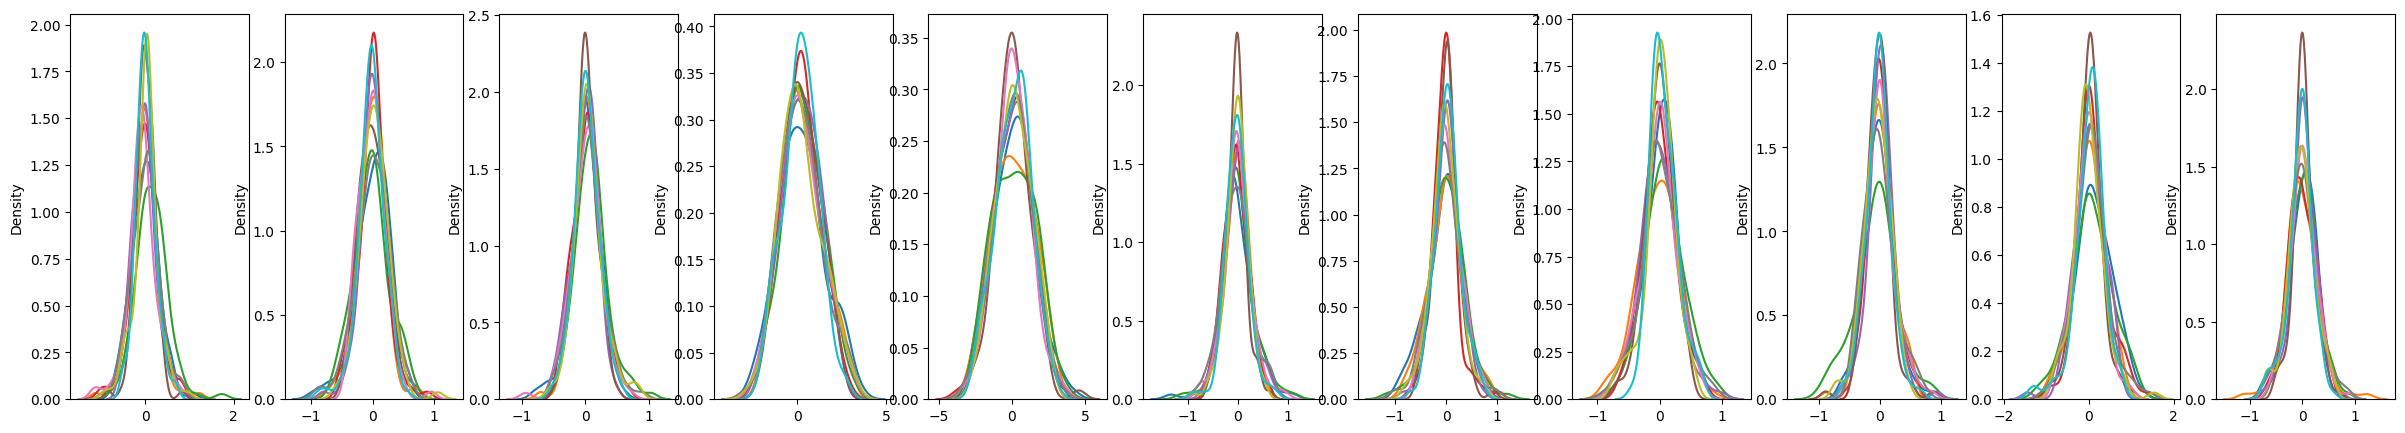

In [ ]:
# fig, ax = plt.subplots(1, 11, figsize=(30, 5))

# for i in range(11):
#     for k in range(10):
#         sns.kdeplot(mix_rff.kernel.kernel.w[k, :, i], ax=ax[i])

## Define and Run Experiment

### Definition

In [17]:
def experiment_run(exp_key, X, y, scaler, params, R, restarts=1):    
    # split data
    X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.1, random_state=int(exp_key[0]))
    X_tr, X_test, y_tr, y_test = jnp.array(X_tr), jnp.array(X_test), jnp.array(y_tr), jnp.array(y_test)

    ############ ORF ############
    # orf_gp, _, _ = build_train_orf(exp_key, X_tr, y_tr, R=R, **params["orf"])
    # orf_preds, orf_sd = orf_gp.condition(y_tr, X_test)
    # orf_metrics = metric_model(y_test, orf_preds, orf_sd, scaler=scaler)

    ############ SVGP ############
    svgp, _ = build_train_svgp(exp_key, X_tr, y_tr, R=R, **params["svgp"])
    svgp_preds, svgp_sd = svgp_predict(svgp, X_test)
    svgp_metrics = metric_model(y_test, svgp_preds, svgp_sd, scaler=scaler)

    ############ RFF RBF ############
    rff_rbf_gp, _ = build_train_rff_rbf(exp_key, X_tr, y_tr, R=R, restarts=restarts, **params["rff_rbf"])
    rff_rbf_preds, rff_rbf_sd = rff_rbf_gp.condition(y_tr, X_test)
    rff_rbf_metrics = metric_model(y_test, rff_rbf_preds, rff_rbf_sd, scaler=scaler)

    ############ RFF ############
    rff_gp, _ = build_train_rff(exp_key, X_tr, y_tr, R=R, restarts=restarts, **params["rff"])
    rff_preds, rff_sd = rff_gp.condition(y_tr, X_test)
    rff_metrics = metric_model(y_test, rff_preds, rff_sd, scaler=scaler)

    ############ RFF-Q ############
    # RFF with the equilvalent number of R as the computational complexity of the mixture.
    q = params["mix_rff"]["q"]
    R_equiv_q = int((q * R**3)**(1/3))
    qrff_gp, _ = build_train_rff(exp_key, X_tr, y_tr, R=R_equiv_q, restarts=restarts, **params["rff"])
    qrff_preds, qrff_sd = qrff_gp.condition(y_tr, X_test)
    qrff_metrics = metric_model(y_test, qrff_preds, qrff_sd, scaler=scaler)

    ############ SRF ############
    srf_gp, _ = build_train_srf(exp_key, X_tr, y_tr, R=R, restarts=restarts, **params["srf"])
    srf_preds, srf_sd = srf_gp.condition(y_tr, X_test)
    srf_metrics = metric_model(y_test, srf_preds, srf_sd, scaler=scaler)

    ############ NRFF ############
    # nrff_gp, _ = build_train_nrff(exp_key, X_tr, y_tr, R=R, restarts=restarts, **params["nrff"])
    # nrff_preds, nrff_sd = nrff_gp.condition(y_tr, X_test)
    # nrff_metrics = metric_model(y_test, nrff_preds, nrff_sd, scaler=scaler)

    ############ MIX ############
    mix_gp, _ = build_train_mix_rff(exp_key, X_tr, y_tr, R=R, restarts=restarts, **params["mix_rff"])
    mix_preds, mix_sd = mix_gp.condition(exp_key, y_tr, X_test)
    mix_metrics = metric_model(y_test, mix_preds, mix_sd, scaler=scaler)

    # # ############ NMIX ############
    # nmix_rff_gp, _ = build_train_nsrf(exp_key, X_tr, y_tr, R=R, **params["nmix_rff"])
    # nmix_rff_preds, nmix_rff_sd = nmix_rff_gp.condition(exp_key, y_tr, X_test)
    # nmix_rff_metrics = metric_model(y_test, nmix_rff_preds, nmix_rff_sd, scaler=scaler)

    metrics = {
        "seed": exp_key[1],
        "svgp": svgp_metrics,
        "rff_rbf": rff_rbf_metrics,
        "rff": rff_metrics,
        "qrff": qrff_metrics,
        "srf": srf_metrics,
        # "nrff": nrff_metrics,
        "mix": mix_metrics,
        # "nmix": nmix_rff_metrics
    }

    return metrics

In [18]:
def multi_run(multi_key, X, y, scaler, params, R, n_runs=10):
    metrics = []
    run_keys = jax.random.split(multi_key, n_runs)

    for i in range(n_runs):
        print(f"Running experiment {i+1} of {n_runs}")
        run_res = experiment_run(run_keys[i], X, y, scaler, params, R)
        metrics.append(run_res)
        print(run_res)
    
    return metrics

### Run

In [32]:
# parameters
KEY, subkey = jax.random.split(jax.random.PRNGKey(42))
params = {
    "svgp": {'epochs': 3500, 'lr': 0.00505763686973616, 'diag': 0.01, 'from_data': True},  # done
    "rff_rbf": {'diag': 0.01058284383544528, 'lr': 0.3783299029837165, 'epochs': 1000, 'init_ls': True}, # done
    "rff": {'diag': 0.020647596678603598, 'lr': 0.2147972751341417, 'epochs': 1000, 'from_data': False, 'init_ls': True},
    "srf": {
        'diag': 0.0016445011018499439, 'lr': 0.2392587812789433, 'lr_gd': 0.3831620299411177, 'alpha': 1.6, 's': 1,  # done
        'epochs': 1000, 'from_data': False, 'gd_params': lambda t: [t.kernel.transform.scale], 'init_ls': True
    },
    "mix_rff": {  # done
        'diag': 0.004082285639051628, 'lr': 0.14002311333326806, 'lr_gd': 0.29379290342643566, 'alpha': 1.6, 'q': 6, 's': 2,
        'epochs': 1000, 'from_data': False, 'gd_params': lambda t: [t.kernel.transform.scale], 'init_ls': True,
        'prior': TFTarget(tfd.Normal(jnp.zeros(d), jnp.ones(d) * 3))
    },
}

In [33]:
# experiment_run(subkey, X_val, y_val, y_scaler, params, R)
res = multi_run(KEY, X, y, y_scaler, params, R=100, n_runs=10)

Running experiment 1 of 10
{'seed': Array(1898466860, dtype=uint32), 'svgp': Array([ 4.09013957e+00,  1.43182131e+00,  9.80132461e-01, -4.53275882e-04],      dtype=float64), 'rff_rbf': Array([ 7.14618767e+00,  1.78253399e+00,  5.62913895e-01, -3.54844309e-05],      dtype=float64), 'rff': Array([ 5.12360734e+00,  1.54343259e+00,  7.81456947e-01, -2.82179345e-03],      dtype=float64), 'qrff': Array([ 6.31306393e+00,  1.44110750e+00,  8.47682118e-01, -2.67389994e-03],      dtype=float64), 'srf': Array([5.92950500e+00, 1.74645669e+00, 2.91390717e-01, 3.65696044e-03],      dtype=float64), 'mix': Array([ 2.16182344e+00,  9.99166236e-01,  7.94701993e-01, -8.43505902e-04],      dtype=float64)}
Running experiment 2 of 10
{'seed': Array(82708574, dtype=uint32), 'svgp': Array([7.71043681e+00, 1.78583339e+00, 9.27152336e-01, 1.19735504e-03],      dtype=float64), 'rff_rbf': Array([1.79593534e+01, 3.04773016e+00, 3.44370872e-01, 3.08097029e-03],      dtype=float64), 'rff': Array([5.83929618e+00, 1.5

In [34]:
res_df = []
for exp in res:
    res_df.extend([[k, *v.tolist()] for k,v in exp.items() if k != "seed"])
res_df = pd.DataFrame(res_df, columns=["model", "mse", "mae", "cal", "z"])
res_df.to_csv("results.csv", index=False)

## Evaluate

In [36]:
res_df = pd.read_csv("results.csv")

names = {
    "rff": "RFF",
    "nrff": "Nonstationary RFF",
    "rff_rbf": "RFF-RBF",
    "svgp": "Sparse VGP",
    "srf": "Stein RFF",
    "qrff": "RFF Equiv Mix Big-O",
    "mix": "Stein Mixture RFF",
    "nmix": "Nonstationary Stein Mixture RFF",
}

res_df["model"] = res_df["model"].apply(lambda x: names[x])
res_df["rmse"] = np.sqrt(res_df["mse"])
res_df["log_mse"] = np.log(res_df["mse"])

In [37]:
sum_df = res_df.groupby("model").agg(["mean", "std"])
sum_df.columns = sum_df.columns.map(lambda x: '_'.join(x) if isinstance(x, tuple) else x)
sum_df = sum_df.sort_values("mse_mean", ascending=True).reset_index()
sum_df

,model,mse_mean,mse_std,mae_mean,mae_std,cal_mean,cal_std,z_mean,z_std,rmse_mean,rmse_std,log_mse_mean,log_mse_std
0,Stein Mixture RFF,2.539034,0.461693,1.064753,0.097878,0.801987,0.036064,0.000201,0.000989,1.587793,0.141213,0.917790,0.173783
1,Sparse VGP,5.520788,1.072069,1.647479,0.115458,0.954967,0.017326,0.000672,0.001889,2.340203,0.221704,1.692654,0.185054
2,RFF Equiv Mix Big-O,5.896643,1.792513,1.513186,0.193979,0.815232,0.034546,-0.000834,0.002185,2.403072,0.368010,1.732301,0.307413
3,RFF,6.148575,2.612893,1.586721,0.356574,0.766225,0.099463,-0.000482,0.002018,2.433846,0.499968,1.743155,0.393227
4,Stein RFF,6.463109,3.338500,1.763796,0.504309,0.263576,0.097321,0.000035,0.002340,2.480254,0.588265,1.771402,0.438153
5,RFF-RBF,8.907712,4.744387,2.067463,0.563424,0.505298,0.107651,0.001255,0.001709,2.896699,0.757808,2.068443,0.505131


Text(0.5, 1.0, 'Airfoil UCI Dataset Error')

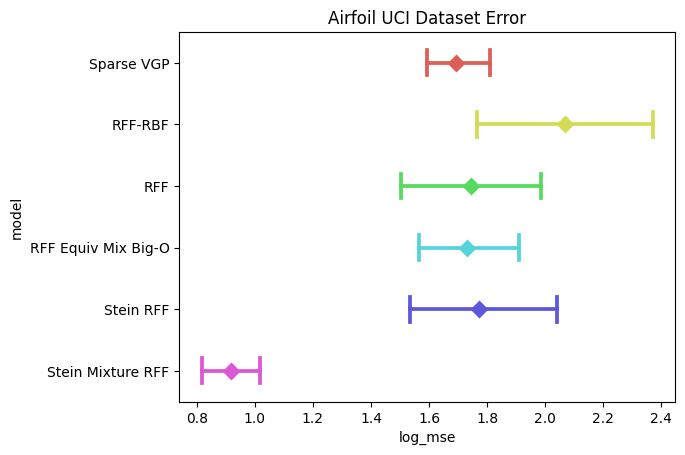

In [38]:
unique_models = res_df["model"].unique()
colors = sns.color_palette("hls", len(unique_models))

pointplot = sns.pointplot(
    data=res_df, x="log_mse", y="model", hue="model",
    errorbar="ci", capsize=.4,
    palette=colors, legend=False,
    color=".5", linestyle="none", marker="D",
)
pointplot.set_title("Airfoil UCI Dataset Error")

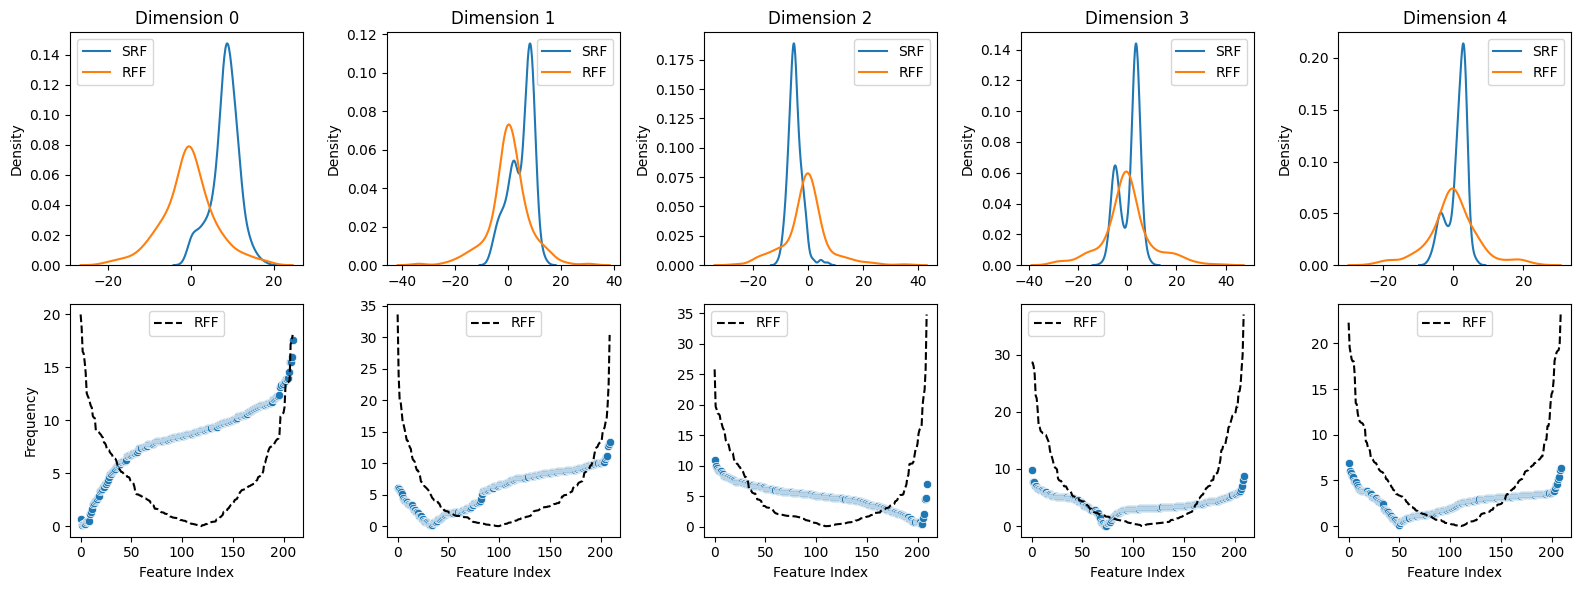

In [69]:
# fig, ax = plt.subplots(2, 5, figsize=(16, 6))

# counter = 0
# for col in range(5):
#     sns.kdeplot(srf_gp.kernel.kernel.w[:, counter], label="SRF", ax=ax[0, col])
#     sns.kdeplot(rff_gp.kernel.kernel.w[:, counter], label="RFF", ax=ax[0, col])
#     ax[0,col].set_title(f"Dimension {counter}")
#     ax[0,col].legend()
#     counter += 1

# counter = 0
# for col in range(5):
#     srf_w = jnp.abs(srf_gp.kernel.kernel.w[:, counter].sort())
#     rff_w = jnp.abs(rff_gp.kernel.kernel.w[:, counter].sort())
#     ind = np.arange(len(srf_w))
#     ax[1, col].plot(ind, rff_w, color="black", linestyle="--", label="RFF")
#     sns.scatterplot(x=ind, y=srf_w, ax=ax[1, col])
#     ax[1, col].set_xlabel("Feature Index")
#     counter += 1

# ax[1, 0].set_ylabel("Frequency")
# plt.tight_layout()